In [1]:
""" initialize the notebook """
import xarray as xr
import numpy as np
import datetime as dt
import scipy.stats
import matplotlib as mpl
import matplotlib.pyplot as PP
import climtrends
import fastkde.fastKDE as fastKDE

mpl.style.use('seaborn-poster')


In [2]:
""" Open the IN dataset and select bloomington"""
precip_xr = xr.open_dataset("IN_GHCN_21Jun2021.nc")
names = precip_xr.name
names.load()
ibloom = np.array(["BLOOMINGTON INDIANA" in name for name in names.values])
bloomington_xr = precip_xr.isel(station = ibloom).squeeze()

In [3]:
""" Calculate Rx1day. """
rx1day = bloomington_xr['PRCP'].groupby(bloomington_xr['time.year']).max(dim = 'time') / 25.4 # inches
rx1day.attrs['long_name'] = "Max Daily Precip"
rx1day.attrs['units'] = "in"

rx2day = bloomington_xr['PRCP'].rolling(time = 2, center = True).sum().groupby(bloomington_xr['time.year']).max(dim = 'time') / 25.4 # inches
rx2day.attrs['long_name'] = "Max 48-hour Precip"
rx2day.attrs['units'] = "in"

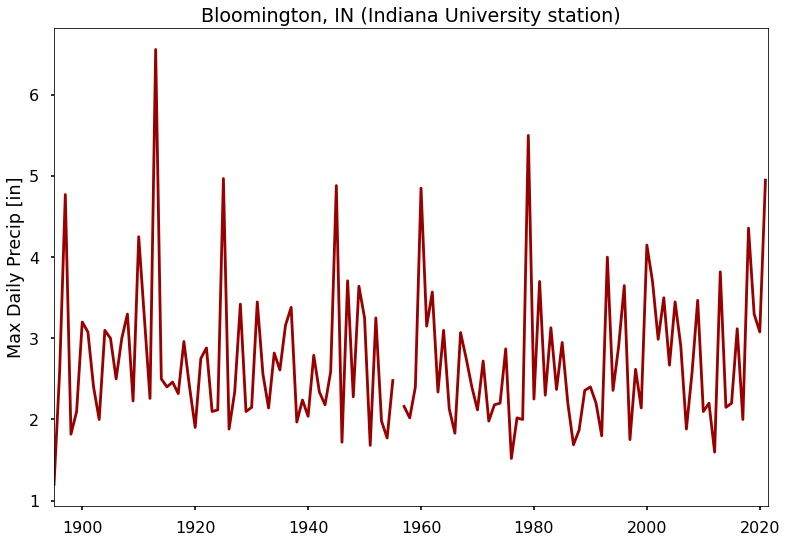

In [4]:
""" Plot rx1day. """

fig, ax = PP.subplots()

rx1day.plot(ax = ax, color = "#990000")

ax.set_title("Bloomington, IN (Indiana University station)")
ax.set_xlabel("")


ax.set_xlim([1895, 2021.5])

#ax.plot([2021, 2021], [5,7], linewidth = 8, color = "#990000", alpha = 0.3)
#ax.text(2023,4.5, "Jun 18-19, 2021 flood", rotation = 90,
#        fontdict = dict(size = 18, color = "#990000"))

PP.savefig("bloomington_rx1day_19Jun2021.png", dpi = 300, bbox_inches = "tight")

PP.show()

In [5]:
class ConstrainedGEVModel(climtrends.TrendGEVModel):
    """ A GEV model that does not permit positive values of xi. """
    
    def log_prior(self,
                  theta):
        """ Returns the log of the prior. 
        
        input:
        ------
        
            theta  : a vector of the model parameters
            
        output:
        -------
        
            log_prior : the log of the prior probability of the model parameters
        
        This implements a uniform distribution by default (this prior is improper), with
        a modification that positive values of xi are not permitted.
        
        
        """
        
        # do a first pass at the starting parameters
        ret_val = super().log_prior(theta)
        
        # TAO: prevent negative values for xi
        if theta[3] > 0:
            return np.nan
        
        # implement a default prior: an unnormalized uniform distribution equal to 1 everywhere
        return ret_val
    
    def get_starting_parameters(self):
        
        # do a first pass at the starting parameters
        starting_parameters = super().get_starting_parameters()
        
        # initialize xi to avoid positive values
        starting_parameters[:,-1] = np.random.uniform(low=-0.3, high = 0.0, size = self.num_walkers)
        
        return starting_parameters
    
# set the random state for repeatability
np.random.seed(0)

rx2day_compressed = rx2day.dropna(dim = 'year')
dates = [ dt.datetime(y, 6, 15) for y in rx2day_compressed.year.values]
model = ConstrainedGEVModel(dates, rx2day_compressed.values, num_burn = 2000, num_walkers = 16, use_thread_pool = True)

model.run_mcmc_sampler(num_samples = 1024)

/N/u/obrienta/BigRed3/.conda/envs/climate_py38/lib/python3.8/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


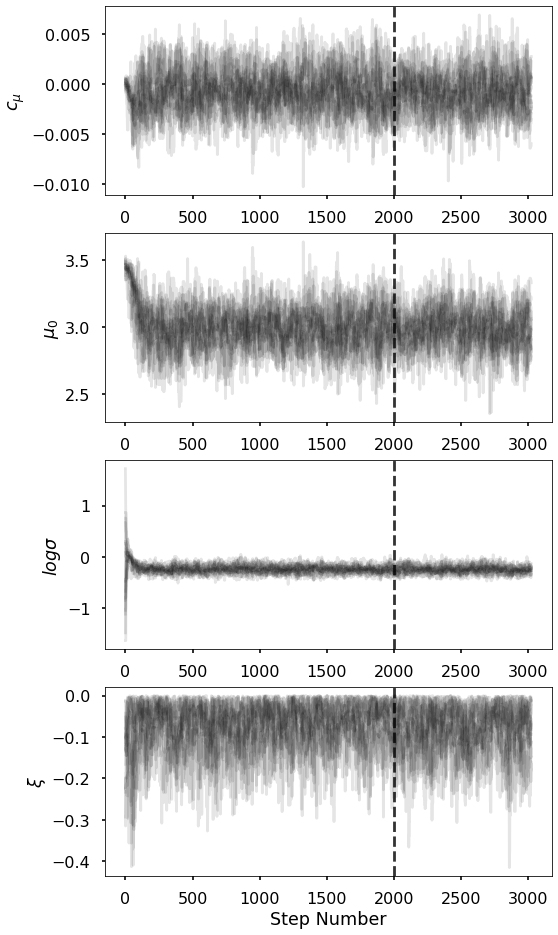

In [6]:
model.plot_mcmc_trace();

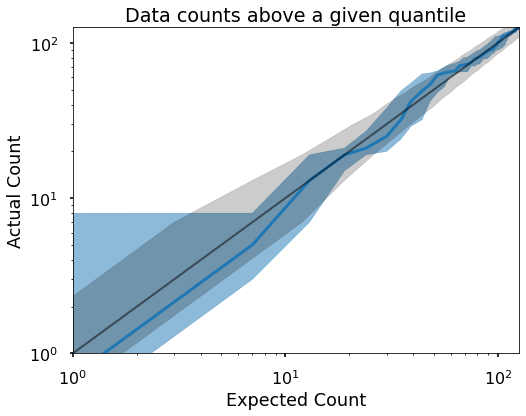

In [7]:
model.plot_nnplot();

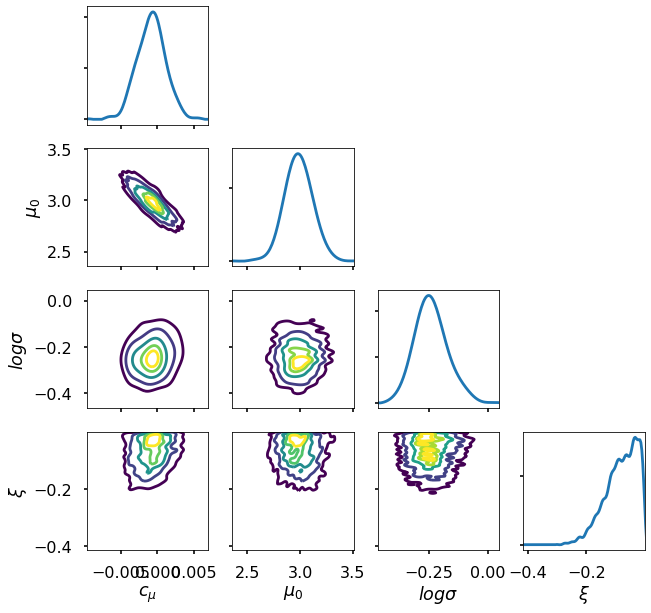

In [8]:
model.plot_pairplots();

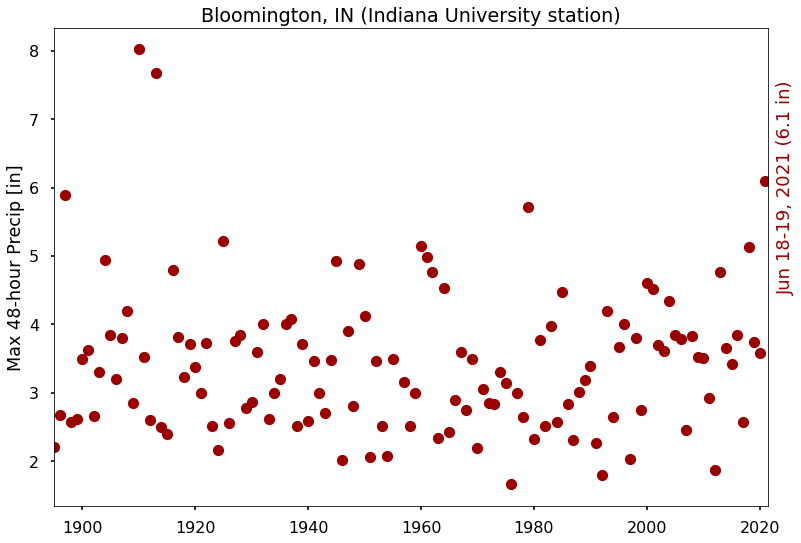

In [9]:
""" Plot rx2day. """

fig, ax = PP.subplots()

rx2day.plot(ax = ax, color = "#990000", linestyle = 'none', marker = 'o')

ax.set_title("Bloomington, IN (Indiana University station)")
ax.set_xlabel("")


ax.set_xlim([1895, 2021.5])

#ax.plot([2021, 2021], [5,7], linewidth = 8, color = "#990000", alpha = 0.3)
ax.text(2023,4.5, f"Jun 18-19, 2021 ({rx2day.values[-1]:2.1f} in)", rotation = 90,
        fontdict = dict(size = 18, color = "#990000"))

PP.savefig("bloomington_rx2day_21Jun2021.png", dpi = 300, bbox_inches = "tight")

PP.show()

28.745782612384588


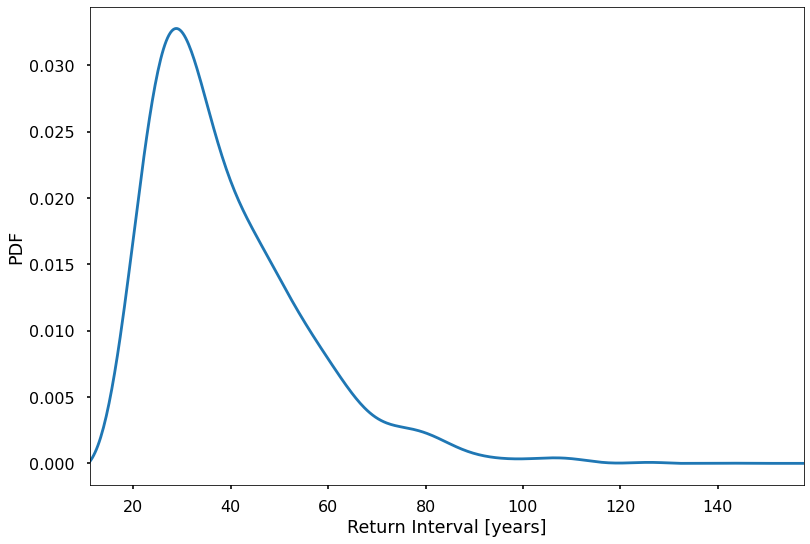

In [10]:
cdf = model.calculate_cdf_values(rx2day.values[-1], dt.datetime(2021,6,18))
rv = 1/(1-cdf)
pdf, axes = fastKDE.pdf(rv, numPoints = 1025)

imax = pdf.argmax()
mode = axes[imax]
print(mode)

fig, ax = PP.subplots()

ax.plot(axes, pdf)
ax.set_xlim([rv.min(), rv.max()])
ax.set_xlabel("Return Interval [years]")
ax.set_ylabel("PDF")

PP.show()